In [3]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))
#import vande.analysis.analysis_roc as ar

In [4]:
import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [5]:
#Data Samples
#DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

#TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
#filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
#batch_size = 128
#train_set_size = int((5*10e3//batch_size)*batch_size)
#_,_, particles_bg = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)

In [6]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
#filename_bg = DATA_PATH + 'QCD_training_data_02_08_2021.h5'
filename_bg = DATA_PATH + 'QCD_training_data_100const_03_08_2021.h5'
inFile = h5py.File(filename_bg, 'r')
particles_bg = inFile['particle_bg'][0:int(5*10e4)]
particles_bg_valid = inFile['particle_bg_valid'][0:int(1*10e4)]
particles_bg_test = inFile['particle_bg_test'][0:int(1*10e4)]
nodes_n = particles_bg.shape[1]
feat_sz = particles_bg.shape[2]

In [7]:
#signal
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

res_width = 'BROAD,NARROW'.split(',')
res_mass = '1.5,3.5'.split(',')
particles_sig_dict = {}

for width in res_width:
    for mass in res_mass:  
        SIG_NAME = 'RSGraviton_WW_'+width+'_13TeV_PU40_'+mass+'TeV_NEW'
        filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
        _,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)
        particles_sig_dict['Graviton '+width+' '+mass] = particles_sig
signal_types = list(particles_sig_dict.keys())        

/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


Number of jets = 9890
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9969
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9854
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9966
Number of constituents (nodes) = 100
Number of features = 3


In [16]:
particles_bg[:,:,0].flatten().shape
#.flatten()

(50000000,)

In [ ]:
new = []
new.append()

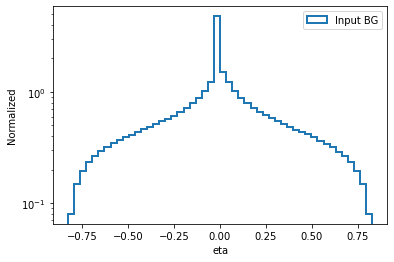

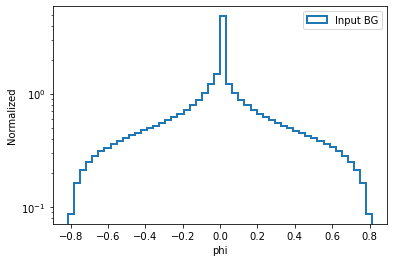

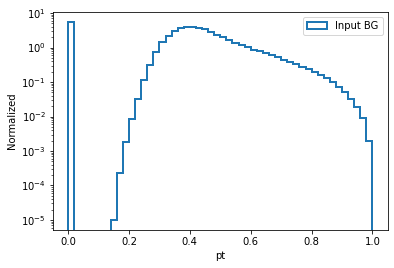

In [25]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

In [8]:
import tensorflow.keras.layers as klayers
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import models.losses as losses
reload(losses)
import models.models as models
reload(models)
import models.layers as layers
reload(layers)
import models.custom_functions as funcs
reload(funcs)
import models.ParticleNetAE as pnae
reload(pnae)

<module 'models.ParticleNetAE' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/ParticleNetAE.py'>

# Particle Net AE

In [9]:
class _DotDict:
    pass

setting = _DotDict()
 # conv_params: list of tuple in the format (K, (C1, C2, C3))
setting.conv_params = [
   (15, ([20,20,20])),
  #      (7, (32, 32, 32)),
  #      (7, (64, 64, 64)),
        ]
#setting.conv_params_decoder = [60,32,16,8, 5]
setting.conv_params_encoder_input = 20 #64 #20
setting.conv_params_encoder = []
setting.conv_params_decoder = [10]  #[32,16,8]
setting.with_bn = True
# conv_pooling: 'average' or 'max' #indeed average seems to perform better
setting.conv_pooling = 'average'
setting.conv_linking = 'sum' #concat or sum
setting.num_points = nodes_n #num of original consituents
setting.num_features = feat_sz #num of original features
setting.input_shapes = {'points': [nodes_n,feat_sz-1],'features':[nodes_n,feat_sz]}
setting.latent_dim = 3
setting.ae_type = 'vae'  #ae or vae 
setting.beta_kl = 1
setting.kl_warmup_time = 0
setting.activation = klayers.LeakyReLU(alpha=0.1)


In [10]:
model = pnae.PNVAE(setting=setting,name='PN_AE_')


Model: "ParticleNetBase"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose (TensorFl [(None, 2, 100)]     0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa [(None, 100, 2)]     0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_BatchMatMulV2 (Tens [(None, 100, 100)]   0           points[0][0]       

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2000)]       0                                            
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            6003        encoder_input[0][0]              
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 3)            6003        encoder_input[0][0]              
__________________________________________________________________________________________________
sampling (Sampling)             (None, 3)            0           z_mean[0][0]                     
                                                                 z_log_var[0][0]            

In [11]:
optim = Adam(learning_rate=0.001)

model.compile(optimizer=optim)

# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

kl_beta_callback = models.KLWarmupCallback()   


In [12]:
import time

# starting time
start = time.time()

history = model.fit((particles_bg[:10000,:,0:2], particles_bg[:10000,:,:]) ,  particles_bg[:10000,:,:],
                    validation_data = ((particles_bg_valid[:10000,:,0:2], particles_bg_valid[:10000,:,:]) , particles_bg_valid[:10000,:,:]),
                    epochs=20, 
                    batch_size=256, 
                    verbose=1,
                    callbacks=[es,ls,kl_beta_callback])

# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")


Epoch 1/20
40/40 [==============================] - 4s 98ms/step - loss: 0.2837 - loss_reco: 0.2824 - loss_latent: 0.0012 - z_mean: 5.6024e-04 - z_log_var: 0.0232 - z: -0.0107 - val_loss: 0.2260 - val_loss_reco: 0.2256 - val_loss_latent: 3.9632e-04
Epoch 2/20
40/40 [==============================] - 3s 84ms/step - loss: 0.1712 - loss_reco: 0.1710 - loss_latent: 1.7759e-04 - z_mean: -3.2867e-06 - z_log_var: 0.0113 - z: -0.0080 - val_loss: 0.1670 - val_loss_reco: 0.1670 - val_loss_latent: 4.4858e-05
Epoch 3/20
40/40 [==============================] - 3s 85ms/step - loss: 0.1328 - loss_reco: 0.1327 - loss_latent: 2.4510e-05 - z_mean: -1.7520e-04 - z_log_var: 0.0023 - z: 0.0090 - val_loss: 0.1299 - val_loss_reco: 0.1299 - val_loss_latent: 2.0415e-05
Epoch 4/20
40/40 [==============================] - 3s 85ms/step - loss: 0.1083 - loss_reco: 0.1083 - loss_latent: 1.9529e-05 - z_mean: -1.2423e-04 - z_log_var: 0.0032 - z: -0.0075 - val_loss: 0.1044 - val_loss_reco: 0.1044 - val_loss_latent: 1

In [318]:
models_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/'
model_path = models_dir + "output_model_saved_PN_AE_2021_08_04_T_16_38"
#"output_model_saved_PN_AE_2021_08_04_T_16_41"
#"output_model_saved_PN_VAE_2021_08_02_T_13_31"
#"output_model_saved_PN_AE_2021_08_02_T_15_52"
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects={"PN_AE": pnae.PNVAE, "threeD_loss":losses.threeD_loss}
)
weights_path = models_dir + "PN_AE_weights_2021_08_04_T_16_38.22-0.018.hdf5"
"PN_AE_weights_2021_08_04_T_16_41.13-0.018.hdf5"
#"PN_VAE_weights_2021_08_02_T_13_31.04-0.033.hdf5"
#'PN_AE_weights_2021_08_02_T_15_52.12-0.022.hdf5'
loaded_model.load_weights(
    weights_path, by_name=True, skip_mismatch=False)

In [319]:
#model = loaded_model

In [382]:
particles_sig_dict['predicted'] = {}
latent_space_bg,Y_bg_predict = model.predict([particles_bg_test[:,:,0:2],particles_bg_test])
for sig in signal_types:
    latent_space_sig,Y_sig_predict = model.predict([particles_sig_dict[sig][:,:,0:2],particles_sig_dict[sig]])
    particles_sig_dict['predicted'][sig] = {}
    particles_sig_dict['predicted'][sig]['latent_space'] = latent_space_sig
    particles_sig_dict['predicted'][sig]['Y_sig_predict'] = Y_sig_predict

In [357]:
#import copy
#sig_out_of_phase_space = copy.deepcopy(particles_sig)
#sig_out_of_phase_space[:,:,2] = sig_out_of_phase_space[:,:,2] +0.5
#_,Y_sig_out_of_phase_space_predict = model.predict([sig_out_of_phase_space[:,:,0:2],sig_out_of_phase_space])

In [383]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
loss_bg_kl = losses.kl_loss_manual(latent_space_bg[1],latent_space_bg[2])

#loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)
particles_sig_dict['loss'] = {}
particles_sig_dict['kl_loss'] = {}
for sig in signal_types:
    particles_sig_dict['loss'][sig] = losses.threeD_loss_manual(particles_sig_dict[sig],particles_sig_dict['predicted'][sig]['Y_sig_predict'])
    particles_sig_dict['kl_loss'][sig] = losses.kl_loss_manual(particles_sig_dict['predicted'][sig]['latent_space'][1],particles_sig_dict['predicted'][sig]['latent_space'][2])

#loss_bg = losses.mse_loss_manual(particles_bg_test,Y_bg_predict)
#loss_sig = losses.mse_loss_manual(particles_sig,Y_sig_predict)



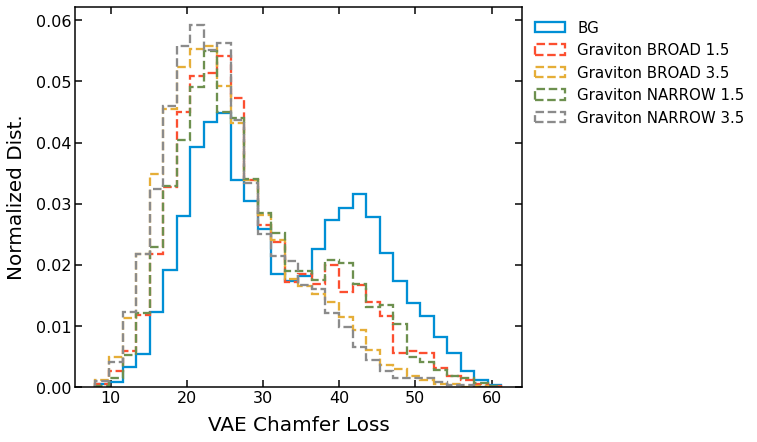

In [384]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = 1.1*np.quantile(loss_bg,0.99)
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2.3)
for sig in signal_types:
    plt.hist(particles_sig_dict['loss'][sig], bins=bins, label=sig, density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=2.3)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_loss_pn_ae.pdf'
plt.savefig(savename)
plt.show()

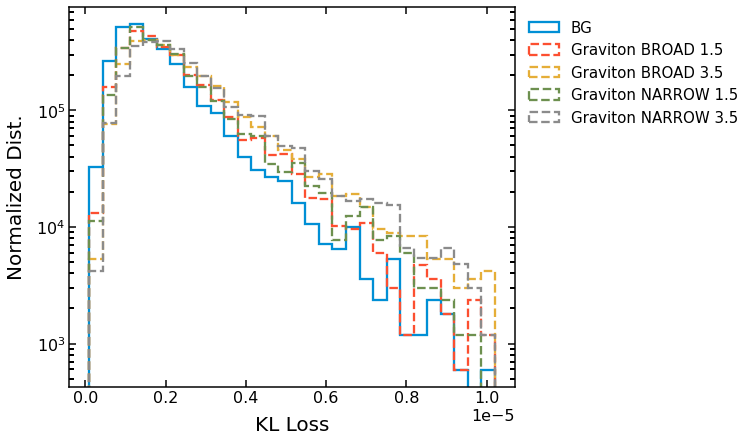

In [385]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = 1.6*np.quantile(loss_bg_kl,0.99)
min_score = np.min(loss_bg_kl)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg_kl, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2.3)
for sig in signal_types:
    plt.hist(particles_sig_dict['kl_loss'][sig], bins=bins, label=sig, density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=2.3)
plt.semilogy()
plt.xlabel("KL Loss")
plt.ylabel("Normalized Dist.")
plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/kl_loss_pn_ae.pdf'
plt.savefig(savename)
plt.show()

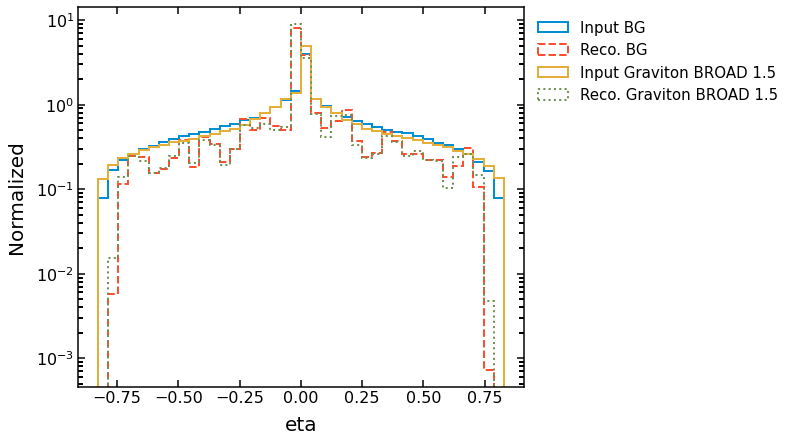

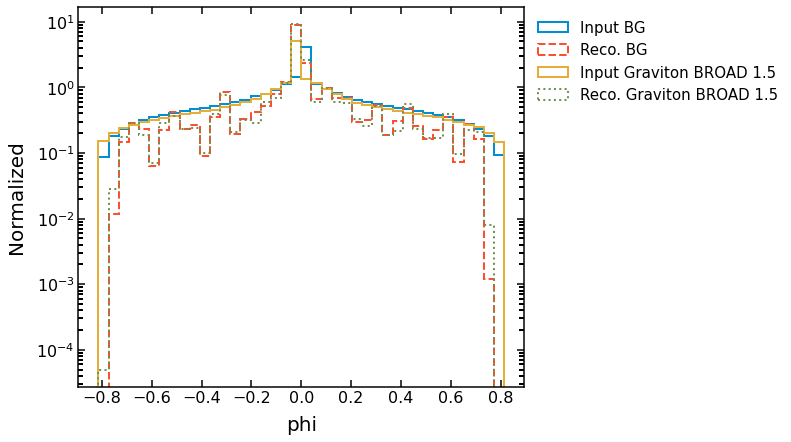

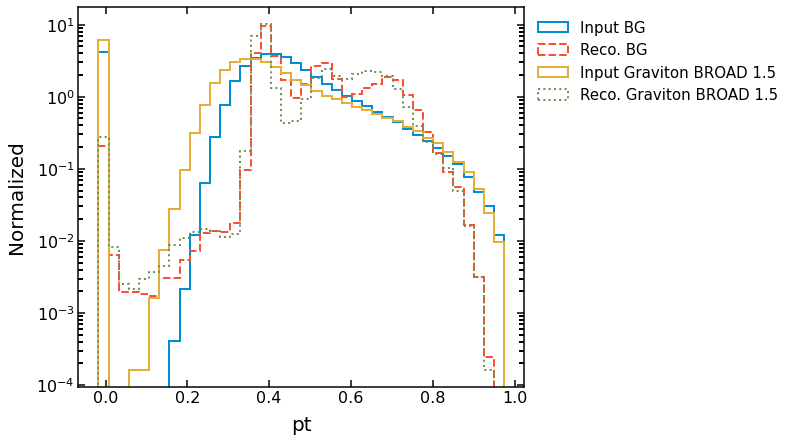

In [360]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    for sig in signal_types[0:1]:       
        _,_,_ = plt.hist(particles_sig_dict[sig][:,:,i].flatten(), bins=bins, label='Input '+sig,density=True, histtype='step', fill=False, linewidth=2)
        _,_,_ = plt.hist(particles_sig_dict['predicted'][sig]['Y_sig_predict'][:,:,i].flatten(), bins=bins, label='Reco. '+sig, linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_vars_pn_ae_{}.pdf'.format(feats[i])
    plt.savefig(savename)
    plt.show()

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning:

divide by zero encountered in true_divide

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning:

divide by zero encountered in true_divide

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning:

divide by zero encountered in true_divide

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning:

divide by zero encountered in true_divide



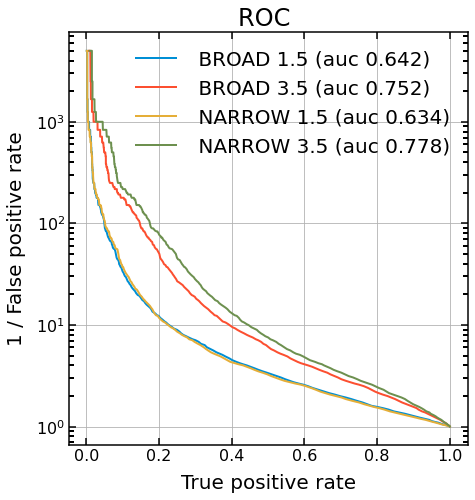

[0.6423260000000001, 0.75198532, 0.63375706, 0.77772248]

In [376]:
neg_class_losses = [loss_bg.tolist()]*len(signal_types)
pos_class_losses = []
for sig in signal_types:
    pos_class_losses.append(particles_sig_dict['loss'][sig])

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=[sig.replace('Graviton','') for sig in signal_types], title='ROC ',
            plot_name='ROC_pn_ae_signals', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


In [ ]:
import json


In [7]:
tf.data.Dataset.from_tensor_slices((particles_bg[:,:,0:2])

SyntaxError: unexpected EOF while parsing (<ipython-input-7-c4e2d0d63405>, line 1)

In [18]:
#dataset= tf.data.Dataset.from_tensor_slices((particles_bg[:,:,0:2], particles_bg))


In [19]:
import plotly.express as px
import plotly.graph_objects as go

In [279]:
setting

In [ ]:
print('h')